## 1. Librerías

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.gridspec import GridSpec
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

plt.style.use("seaborn-v0_8")
sns.set_style("white", {"axes.facecolor" : "white"})
pd.options.display.max_columns = 1000

## 2. Funciones

In [6]:
def df_status(df):

    num_filas = df.shape[0]

    dfZeros = (
        (df == 0)
        .sum(axis = 0)
        .reset_index(name = "q_zeros")
        .assign(p_zeros = lambda x : round(x.q_zeros / num_filas * 100, 2))
    )

    dfNa = (
        df
        .isnull()
        .sum(axis = 0)
        .reset_index(name = "q_na")
        .assign(p_na = lambda x : round(x.q_na / num_filas * 100, 2))
    )

    dfType = (
        df
        .dtypes
        .reset_index(name = "type")
        .assign(type = lambda x : x.type.astype(str))
    )

    dfUnique = (
        df
        .nunique()
        .reset_index(name = "unique")
    )

    dfstatus = (
        dfZeros
        .merge(dfNa, on = "index", how = "left")
        .merge(dfType, on = "index", how = "left")
        .merge(dfUnique, on = "index", how = "left")
        .rename(columns = {"index" : "variable"})
    )

    return dfstatus

## 3. Cargando datos

In [7]:
dataset_spam = pd.read_csv("spam.csv", sep = ",")

In [8]:
dataset_spam

,crl.tot,dollar,bang,money,n000,make,yesno
0,278,0.000,0.778,0.00,0.00,0.00,y
1,1028,0.180,0.372,0.43,0.43,0.21,y
2,2259,0.184,0.276,0.06,1.16,0.06,y
3,191,0.000,0.137,0.00,0.00,0.00,y
4,191,0.000,0.135,0.00,0.00,0.00,y
...,...,...,...,...,...,...,...
4596,88,0.000,0.000,0.00,0.00,0.31,n
4597,14,0.000,0.353,0.00,0.00,0.00,n
4598,118,0.000,0.000,0.00,0.00,0.30,n
4599,78,0.000,0.000,0.00,0.00,0.96,n


## 4. Calidad de los datos

In [9]:
dfStatusData = df_status(dataset_spam)
dfStatusData

,variable,q_zeros,p_zeros,q_na,p_na,type,unique
0,crl.tot,0,0.00,0,0.0,int64,919
1,dollar,3201,69.57,0,0.0,float64,504
2,bang,2343,50.92,0,0.0,float64,964
3,money,3866,84.03,0,0.0,float64,143
4,n000,3922,85.24,0,0.0,float64,164
5,make,3548,77.11,0,0.0,float64,142
6,yesno,0,0.00,0,0.0,object,2


## 5. Análisis exploratorio de datos

In [10]:
variables_cuantitativas = dfStatusData.query("type != 'object'")["variable"].to_list()
variables_cuantitativas

['crl.tot', 'dollar', 'bang', 'money', 'n000', 'make']

In [11]:
variables_categoricas = dfStatusData.query("type == 'object'")["variable"].to_list()
variables_categoricas

['yesno']

### 5.1. Univariado

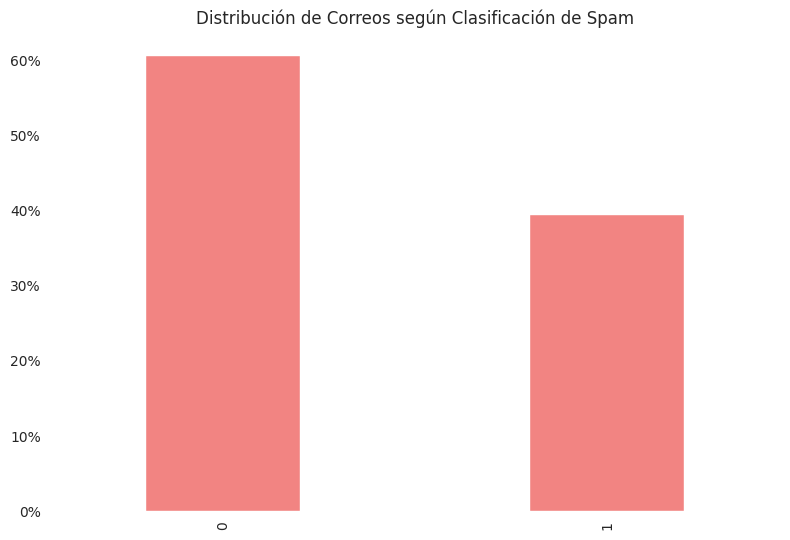

In [12]:
(
    dataset_spam[variables_categoricas]
    .value_counts(normalize = True)
    .reset_index()
    .plot(kind = "bar",
          title = "Distribución de Correos según Clasificación de Spam",
          width = 0.4,
          legend = False,
          color = ["#f28482"]
    )
    .yaxis.set_major_formatter(FuncFormatter(lambda x, p : f"{round(x * 100)}%"))
)

plt.tight_layout()
plt.show()

* No presentamos un caso de desbalanceo de datos (más del 90% de casos en una de las dos clases)
* Mayoría de correos no son SPAM

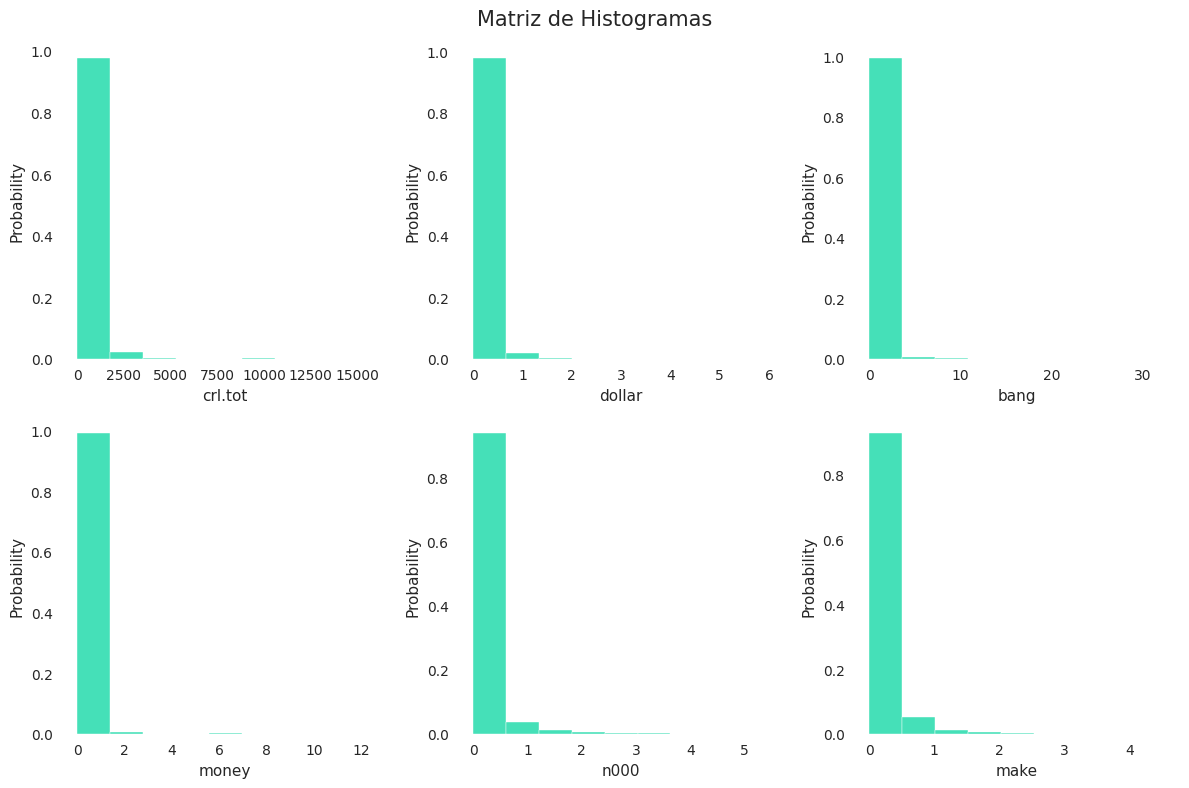

In [13]:
fig = plt.figure(figsize = (12, 8))
gs = GridSpec(nrows = 2, ncols = 3)

for i, variable in enumerate(variables_cuantitativas):
    ax = plt.subplot(gs[i])

    ax2 = sns.histplot(data = dataset_spam, x = variable, stat = "probability", bins = 9, ax = ax, color = "#06d6a0")

plt.suptitle("Matriz de Histogramas", fontsize = 15)
plt.tight_layout()
plt.show()

* La mayoría de correos se mantiene con todas las características en un rangon mínimo

In [14]:
dataset_spam[variables_cuantitativas].describe().T

,count,mean,std,min,25%,50%,75%,max
crl.tot,4601.0,283.289285,606.347851,1.0,35.0,95.0,266.000,15841.000
dollar,4601.0,0.075811,0.245882,0.0,0.0,0.0,0.052,6.003
bang,4601.0,0.269071,0.815672,0.0,0.0,0.0,0.315,32.478
money,4601.0,0.094269,0.442636,0.0,0.0,0.0,0.000,12.500
n000,4601.0,0.101645,0.350286,0.0,0.0,0.0,0.000,5.450
make,4601.0,0.104553,0.305358,0.0,0.0,0.0,0.000,4.540


### 5.2. Bivariado

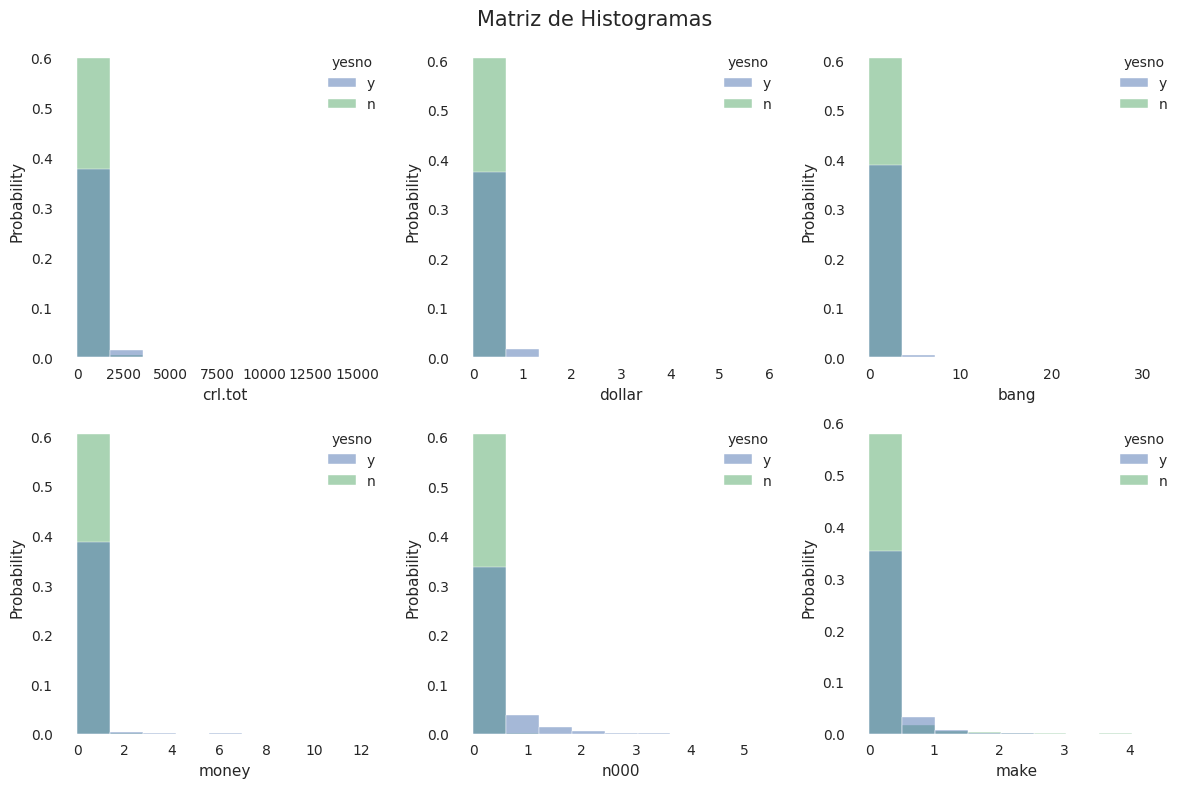

In [15]:
fig = plt.figure(figsize = (12, 8))
gs = GridSpec(nrows = 2, ncols = 3)

for i, variable in enumerate(variables_cuantitativas):
    ax = plt.subplot(gs[i])

    ax2 = sns.histplot(data = dataset_spam, x = variable, stat = "probability", bins = 9, ax = ax, hue = "yesno")

plt.suptitle("Matriz de Histogramas", fontsize = 15)
plt.tight_layout()
plt.show()

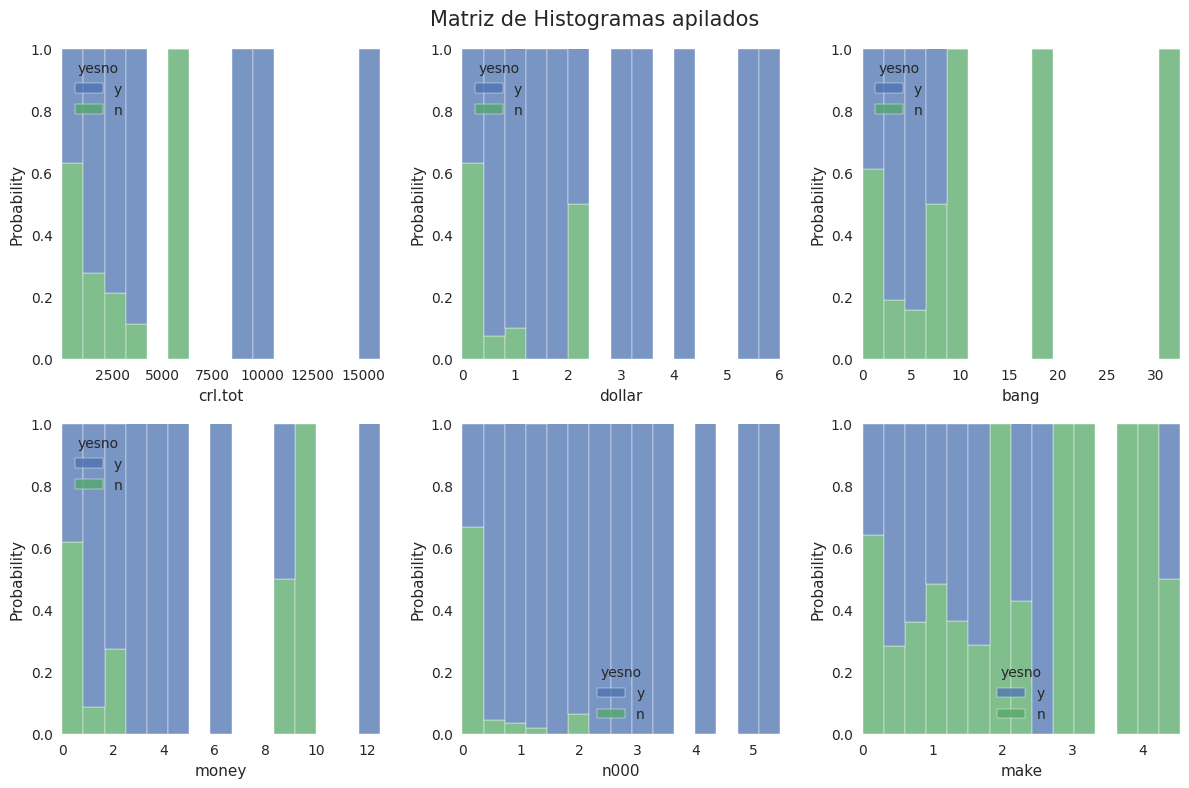

In [16]:
fig = plt.figure(figsize = (12, 8))
gs = GridSpec(nrows = 2, ncols = 3)

for i, variable in enumerate(variables_cuantitativas):
    ax = plt.subplot(gs[i])

    ax2 = sns.histplot(data = dataset_spam, x = variable, stat = "probability", bins = 15, ax = ax, hue = "yesno", multiple = "fill")

plt.suptitle("Matriz de Histogramas apilados", fontsize = 15)
plt.tight_layout()
plt.show()

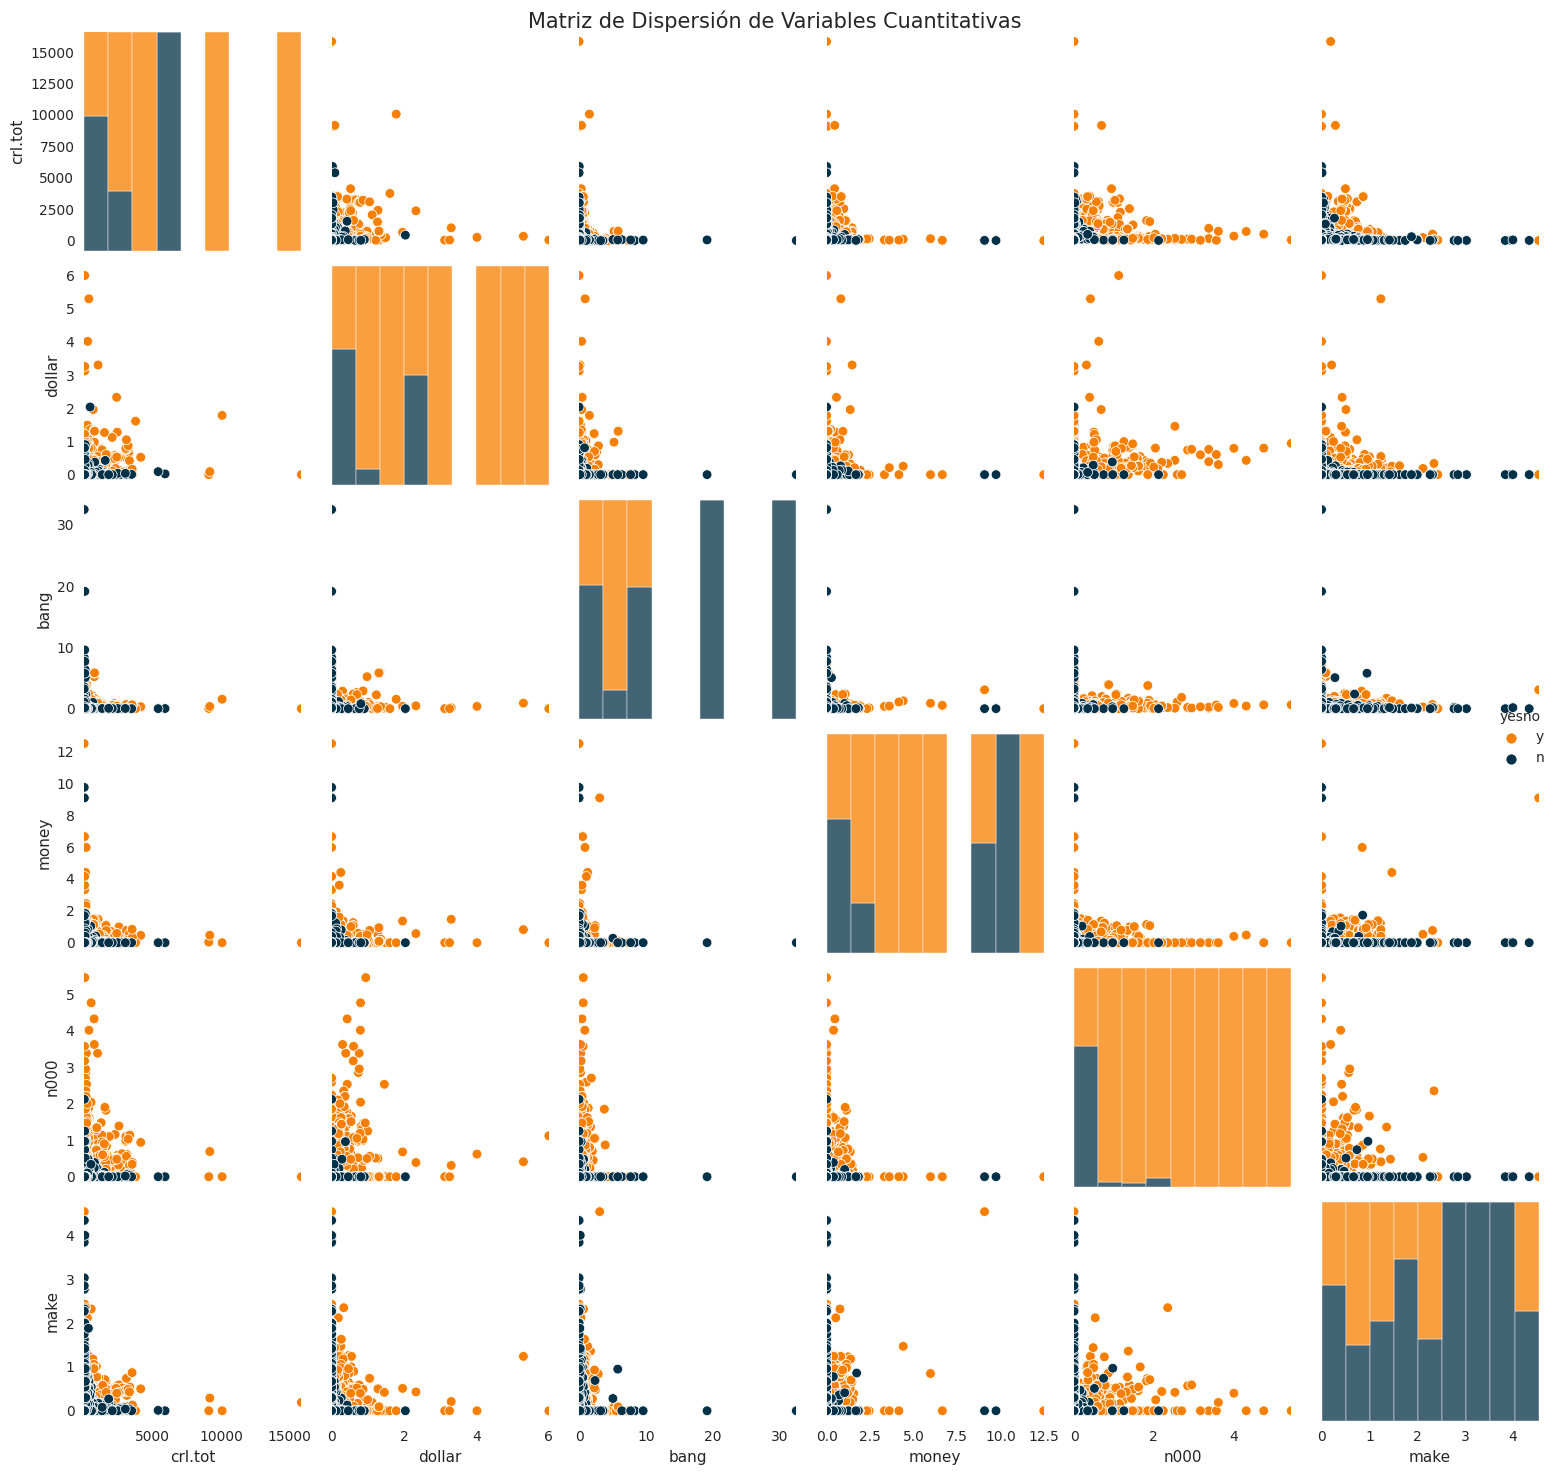

In [17]:
ax = sns.pairplot(
    data = dataset_spam,
    x_vars = variables_cuantitativas,
    y_vars = variables_cuantitativas,
    diag_kind = "hist",
    hue = "yesno",
    palette = ["#f77f00", "#023047"],
    diag_kws = {"multiple" : "fill",
                "bins" : 9}
)
plt.suptitle("Matriz de Dispersión de Variables Cuantitativas", size = 15)
plt.tight_layout()
plt.show()

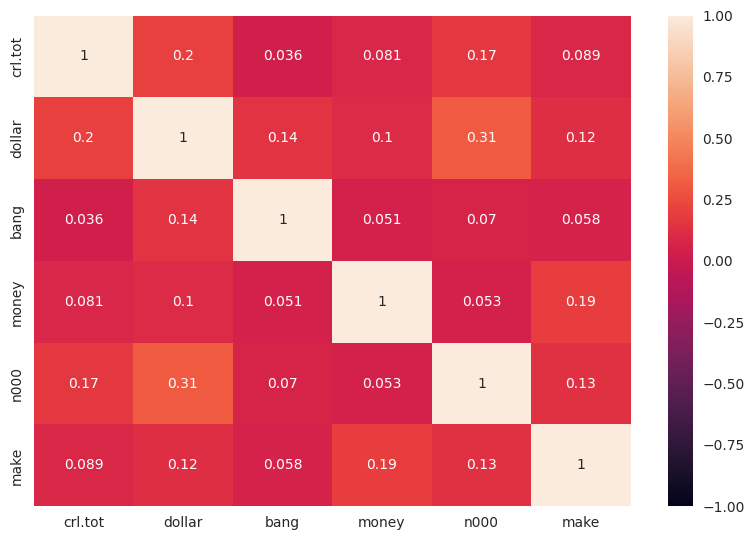

In [18]:
sns.heatmap(dataset_spam[variables_cuantitativas].corr(), annot = True, vmin = -1, vmax = 1)
plt.tight_layout()
plt.show()

* Se tiene que ninguna variable está fuertemente correlacionada consigo misma, incluso si es spam o no

## 6. Preparación de datos

In [19]:
reemplazo_etiquetas = {
    "y" : 1,
    "n" : 0
}

dataset_spam_p = (
    dataset_spam
    .assign(yesno = lambda x : x["yesno"].replace(reemplazo_etiquetas))
)

In [20]:
X = dataset_spam_p.drop(columns = "yesno")
y = dataset_spam_p["yesno"]

In [23]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.3, random_state = 23, stratify = y)

In [24]:
mod_logistico = LogisticRegression(C=1.0, class_weight = None, dual = False, fit_intercept = True,
                                   intercept_scaling = 1, l1_ratio = None, max_iter = 1000,
                                   multi_class = 'auto', n_jobs = None, penalty = 'l2',
                                   random_state = None, solver = 'lbfgs', tol = 0.0001, verbose = 0,
                                   warm_start = False)

In [25]:
mod_logistico.fit(XTrain, yTrain)

LogisticRegression(max_iter=1000)

In [26]:
pred_test = mod_logistico.predict(XTest)
pred_train = mod_logistico.predict(XTrain)

In [27]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [28]:
print(f"Se tiene un: {roc_auc_score(yTest, pred_test)} en AUC para la partición de prueba con el modelo logístico")
print(f"Se tiene un: {roc_auc_score(yTrain, pred_train)}% en AUC para la partición de entrenamiento con el modelo logístico")

Se tiene un: 0.7907651187715229 en AUC para la partición de prueba con el modelo logístico
Se tiene un: 0.788792920645653% en AUC para la partición de entrenamiento con el modelo logístico


In [29]:
print(f"Se tiene un: {round(accuracy_score(yTest, pred_test), 2) * 100}% en Precisión para la partición de prueba con el modelo logístico")
print(f"Se tiene un: {round(accuracy_score(yTrain, pred_train), 2) * 100}% en Presición para la partición de entrenamiento con el modelo logístico")

Se tiene un: 82.0% en Precisión para la partición de prueba con el modelo logístico
Se tiene un: 82.0% en Presición para la partición de entrenamiento con el modelo logístico


In [30]:
from sklearn.metrics import confusion_matrix

In [31]:
pd.DataFrame(confusion_matrix(yTest, pred_test))

,0,1
0,796,41
1,201,343


In [32]:
from sklearn.tree import DecisionTreeClassifier

In [33]:
mod_arbol_cart = DecisionTreeClassifier(class_weight = None, criterion = 'gini', max_depth = None,
                                        max_features = None, max_leaf_nodes = None, min_samples_leaf = 1,
                                        min_samples_split = 2, min_weight_fraction_leaf = 0.0, random_state = 23, splitter = 'best')


In [34]:
mod_arbol_cart.fit(XTrain,yTrain)

DecisionTreeClassifier(random_state=23)

In [35]:
pred_test_arbol = mod_arbol_cart.predict(XTest)
pred_train_arbol = mod_arbol_cart.predict(XTrain)

In [36]:
print(f"Se tiene un: {roc_auc_score(yTest, pred_test_arbol)} en AUC para la partición de prueba con el modelo de árbol")
print(f"Se tiene un: {roc_auc_score(yTrain, pred_train_arbol)} en AUC para la partición de entrenamiento con el modelo de árbol")

Se tiene un: 0.8398945375641296 en AUC para la partición de prueba con el modelo de árbol
Se tiene un: 0.9691677784199895 en AUC para la partición de entrenamiento con el modelo de árbol


In [37]:
print(f"Se tiene un: {round(accuracy_score(yTest, pred_test_arbol), 2) * 100}% en Precisión para la partición de prueba con el modelo de árbol")
print(f"Se tiene un: {round(accuracy_score(yTrain, pred_train_arbol), 2) * 100}% en Presición para la partición de entrenamiento con el modelo de árbol")

Se tiene un: 85.0% en Precisión para la partición de prueba con el modelo de árbol
Se tiene un: 98.0% en Presición para la partición de entrenamiento con el modelo de árbol


In [38]:
pd.DataFrame(confusion_matrix(yTest, pred_test_arbol))

,0,1
0,749,88
1,117,427
